<a href="https://colab.research.google.com/github/AlexEskin/LidarMaps/blob/master/MapsFilter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

fatal: destination path 'LidarMaps' already exists and is not an empty directory.
[256.0, 307.2]
[234.0, 285.2]
[230.0, 303.2]
[225.0, 323.2]
[234.0, 349.2]
[241.0, 320.2]
[242.0, 327.2]
[240.0, 297.2]
[229.0, 305.2]
[219.0, 331.2]
[240.0, 336.2]
[256.0, 363.2]
[248.0, 369.2]
[231.0, 396.2]
[246.0, 413.2]
[222.0, 420.2]
[252.0, 413.2]


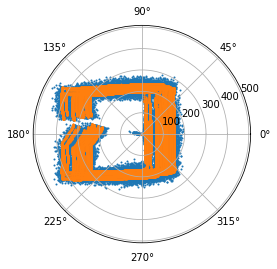

In [1]:
!git clone https://github.com/AlexEskin/LidarMaps.git
import cv2
import math
import numpy as np 
import random

im_a = cv2.imread("LidarMaps/template.png",0)
basis_point = (0,0.2)
shape = im_a.shape
basis_point = [basis_point[0]*shape[0]/2 + shape[0]/2, basis_point[1]*shape[1]/2 + shape[1]/2]

def ray(image, basis_point, angle):
	vector = np.array((math.sin(angle),math.cos(angle)))
	coordinates = np.array([basis_point[0],basis_point[1]])
	distance = 0
	while True:
		if (image.shape<=coordinates).any() or (coordinates<0).any():
			return 0
		cr = coordinates.astype(int)
		if image[cr[0]][cr[1]] != 255:
			return distance
		distance += 1
		coordinates = coordinates+vector
def add_noise(x):
  if x!=None:
    x+=np.random.normal()*16
    x*=random.randint(100,104)/102.0
    if random.randint(0,16)<4:
      x = 0
  else:
    x = 0
  return x
print(basis_point)
u_l = []
u_noised = []
v_l = []
rotations = 16
for i in range(0,3600*rotations):
  if (i%3600 == 0):
    
    basis_point[0] += (random.randint(-30,30))
    basis_point[1] += (random.randint(-30,30))
    print (basis_point)

  v = i/(10*2*math.pi)
  u = ray(im_a, basis_point, v)
  u_noised.append(add_noise(u))
  u_l.append(u)
  v_l.append(v)

import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(v_l,u_noised,s=1)
c = ax.scatter(v_l,u_l,s=1)

plt.show()

In [0]:
%tensorflow_version 2.x

from keras.datasets import imdb
from tensorflow.keras.layers import GRU, LSTM, Activation, Bidirectional,Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
import numpy as np
import tensorflow as tf
import random
import os

num_words = 29696
maxlen = 32

#(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = num_words)
# print(typeof(X_train))
# print(y_train[0])
X_train = [[],]*num_words
y_train = [[],]*num_words
scale_factor = 255.0
for i in range(len(X_train)):
  X_train[i] = []
  for j in range(maxlen):
    val = u_noised[i+j]
    val /= scale_factor
    X_train[i].append(val)
  X_train[i] = np.array(X_train[i]).astype(np.float32)
  y_train[i] = u_l[i+maxlen]/scale_factor
y_train = np.array(y_train).astype(np.float32)

X_train = np.array(X_train).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
X_train = X_train.reshape(X_train.shape + (1,))

def gru_model():
  model = tf.keras.Sequential()

  model.add(Bidirectional(LSTM(128, return_sequences=True), 
                                input_shape=(maxlen, 1)))
  model.add(Bidirectional(LSTM(64)))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='relu'))

  model.summary()
  return model
    
import os

strategy = None
if 'COLAB_TPU_ADDR' in os.environ:
  resolver = tf.contrib.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.contrib.distribute.initialize_tpu_system(resolver)
  strategy = tf.contrib.distribute.TPUStrategy(resolver)

#with strategy.scope():
model = gru_model()
model.compile(tf.keras.optimizers.SGD(momentum=0.9),loss='mean_squared_error')
model.fit(X_train, y_train, batch_size = 512, epochs = 60, verbose =1 )

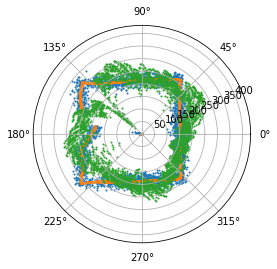

In [5]:
result = model.predict(X_train[0:3600])*scale_factor

fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(v_l[0:3600],u_noised[0:3600],s=1)
c = ax.scatter(v_l[0:3600],u_l[0:3600],s=1)
c = ax.scatter(v_l[0:3600],result,s=1)

plt.show()

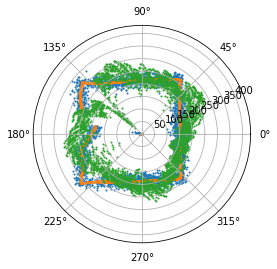